# Erbium-Doped Optical Fiber Amplifiers

**Scott Prahl**

**Aug 2021**

In [1]:
#!pip install --user ofiber

In [2]:
# Jupyterlite support for ofiber
try:
    import micropip
    await micropip.install("ofiber")
except ModuleNotFoundError:
    pass

try:
    import numpy as np
    import matplotlib.pyplot as plt
    import scipy
    import scipy.integrate
    import ofiber

except ModuleNotFoundError:
    print('ofiber is not installed. To install, uncomment and run the cell above.')
    print('Once installation is successful, rerun this cell again.')

# to make graphs a bit better
%config InlineBackend.figure_format='retina'
plt.style.use('seaborn-talk')

In [3]:
q = scipy.constants.eV             # Joules
c = scipy.constants.speed_of_light # m/s
k = scipy.constants.Boltzmann      # J/Kelvin
h = scipy.constants.Planck

cross_lambda = 1e-9*np.array([1500.3, 1505.5, 1509.7, 1514.9, 1520.2, 1525.4, 1530.6, 1535.9, 1540.1, 1545.3, 1550.5, 1555.8, 1560.0, 1565.2, 1570.4, 1575.7, 1579.8, 1585.1, 1590.3, 1595.6, 1600.8, 1605.0, 1610.2, 1615.5, 1619.6, 1624.9, 1630.1, 1635.3, 1640.6])

cross_sigma_a = 1e-25*np.array([ 2.257, 2.403, 2.553, 2.744, 3.365, 4.421, 5.379, 4.644, 3.154, 2.850, 2.545, 2.229, 1.859, 1.303, 0.934, 0.759, 0.654, 0.576, 0.503, 0.459, 0.442, 0.402, 0.378, 0.345, 0.325, 0.292, 0.276, 0.252, 0.252])

cross_sigma_se = 1e-25*np.array([ 1.133, 1.340, 1.514, 1.884, 2.489, 3.495, 4.709, 4.644, 3.503, 3.386, 3.410, 3.057, 2.801, 2.180, 1.717, 1.303, 1.133, 0.978, 0.889, 0.804, 0.727, 0.670, 0.609, 0.544, 0.487, 0.426, 0.369, 0.309, 0.268])

def absorption_cross_section(λ):
    '''
    Return the absorption cross section (m**2) for a typical erbium doped fiber
    at a wavelength λ (m) based on ghatak Table 14.1
    '''
    return np.interp(λ, cross_lambda, cross_sigma_a)

def emission_cross_section(λ):
    '''
    Return the emission cross section (m**2) for a typical erbium doped fiber
    at a wavelength λ (m) based on ghatak Table 14.1
    '''
    return np.interp(λ, cross_lambda, cross_sigma_se)

## Figure 14.13

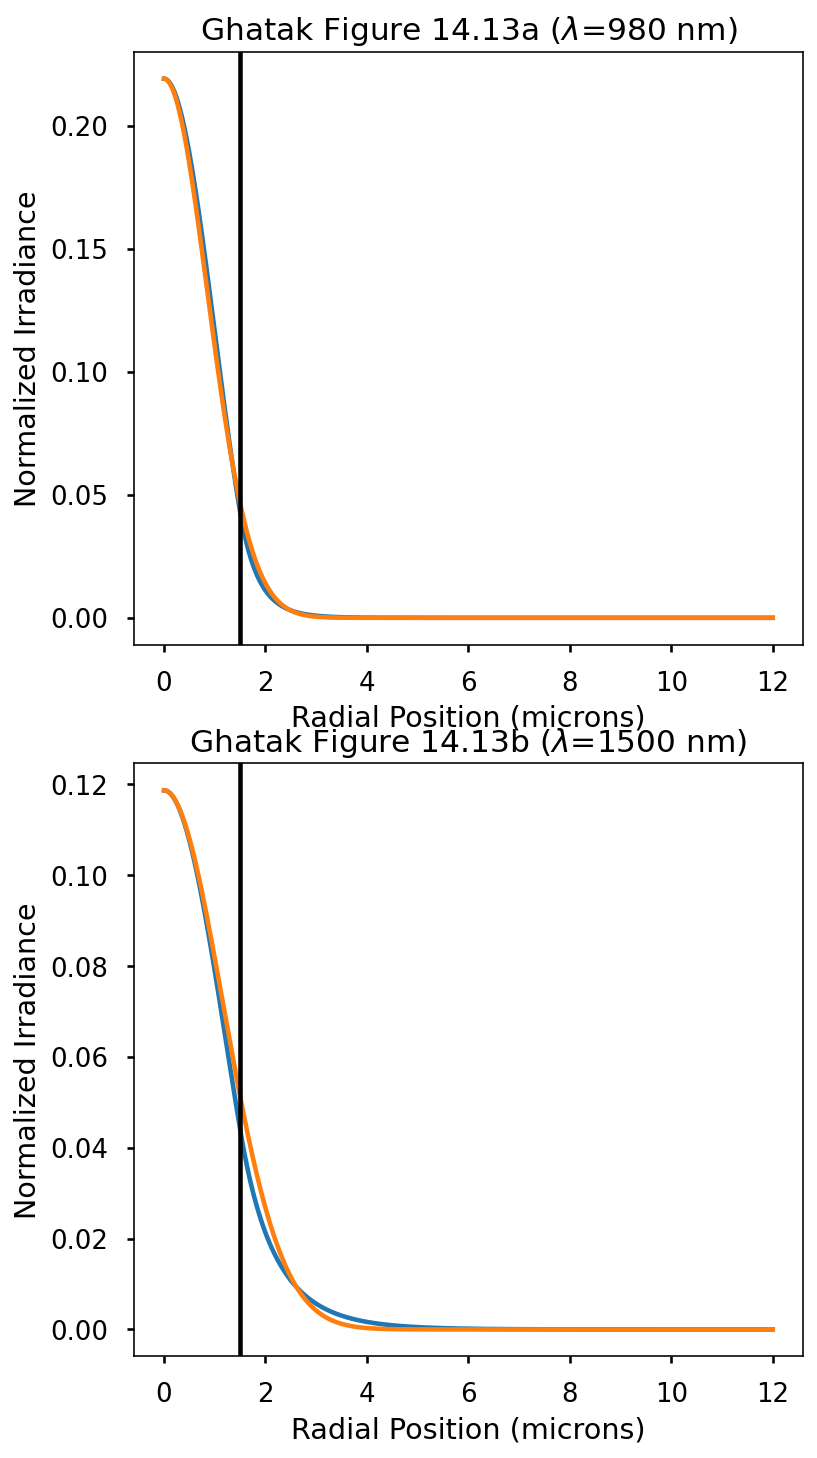

In [4]:
ell = 0
em = 1
core_radius = 1.5e-6
NA = 0.24
r = np.linspace(0,8* core_radius,2000)
area = np.pi *  core_radius**2

plt.subplots(2,1,figsize=(6,12))
λ = 980e-9
V = ofiber.V_parameter( core_radius,NA,λ)
b = ofiber.LP_mode_value(V, ell, em)
E_true = ofiber.LP_radial_irradiance(V, b, ell, r/ core_radius)/area
E_env  = ofiber.gaussian_radial_irradiance(V, r/ core_radius)/area  
plt.subplot(2,1,1)
plt.plot(r*1e6, E_true*1e-12)
plt.plot(r*1e6, E_env*1e-12)
plt.axvline( core_radius*1e6, color='black')
plt.xlabel("Radial Position (microns)")
plt.ylabel("Normalized Irradiance")
plt.title('Ghatak Figure 14.13a ($\lambda$=%.0f nm)'% (λ*1e9))

λ = 1500e-9
V = ofiber.V_parameter( core_radius,NA,λ)
b = ofiber.LP_mode_value(V, ell, em)
E_true = ofiber.LP_radial_irradiance(V, b, ell, r/ core_radius)/area
E_env  = ofiber.gaussian_radial_irradiance(V, r/ core_radius)/area  
plt.subplot(2,1,2)
plt.plot(r*1e6, E_true*1e-12)
plt.plot(r*1e6, E_env*1e-12)
plt.axvline( core_radius*1e6, color='black')
plt.xlabel("Radial Position (microns)")
plt.ylabel("Normalized Irradiance")
plt.title('Ghatak Figure 14.13b ($\lambda$=%.0f nm)'% (λ*1e9))


plt.show()

## Normalization
The total power is normalized to the area of the core
$$
\frac{2\pi}{\pi a^2} \int_0^\infty \mbox{gaussian_radial_irradiance}(r) r dr = 1
$$
thus if $f(r)$=`gaussian_radial_irradiance(V,r/a)/(np.pi*a**2)` then
$$
2\pi \int_0^\infty f(r) r dr = 1
$$

In [5]:
print(2*np.trapz(E_env*area*r/ core_radius, r/ core_radius) )

print(2*np.pi*np.trapz(E_env*r, r) )

print(2*np.trapz(E_true*area*r/ core_radius, r/ core_radius) )

print(2*np.pi*np.trapz(E_true*r, r) )

0.9999977611012747
0.9999977611012746
0.9999780668306247
0.9999780668306248


## Figures 14.14

This is simple because it is a single non-linear ODE


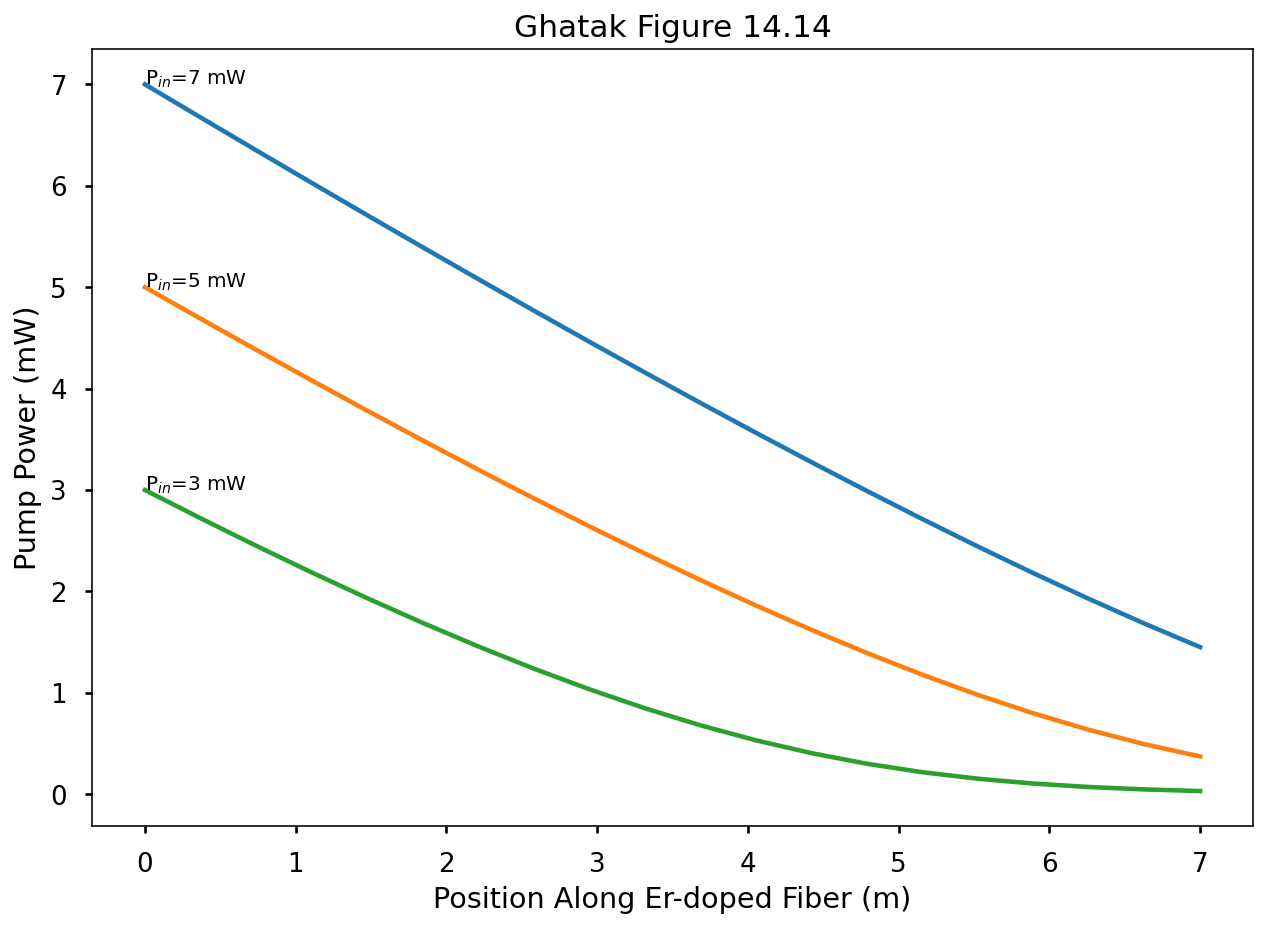

In [6]:
def dPp_dz(Pp, z, Pp0, N_0, abs_pump, b_over_omega):
    '''equation 14.56 in Ghatak'''
    return abs_pump * Pp0 * N_0 * np.log((1+(Pp/Pp0)*np.exp(-b_over_omega**2))/(1+Pp/Pp0))

lambda_pump = 980e-9   # m
N_0         = 6.8e24   # Er ions per m**3
core_radius      = 1.64e-6  # m fiber core
doped_radius     =  core_radius   # m Er doping radius
NA          = 0.21
Ip0         = 7.81e7   # W/m**2

abs_pump   = absorption_cross_section(lambda_pump)
V_pump = ofiber.V_parameter( core_radius, NA, lambda_pump)
Omega_pump = ofiber.gaussian_envelope_Omega(V_pump) *  core_radius
b_over_omega = doped_radius / Omega_pump
Pp0 = Ip0 * np.pi * Omega_pump**2

z = np.linspace(0,7,20)  # meters along doped fiber

Pin = 7 # mW
sol = scipy.integrate.odeint(dPp_dz, Pin*1e-3, z, args=(Pp0, N_0, abs_pump, b_over_omega))
Pp = sol[:,0]
plt.plot(z,Pp*1e3)
plt.text(0,Pin,"P$_{in}$=%.0f mW" % Pin)

Pin = 5 # mW
sol = scipy.integrate.odeint(dPp_dz, Pin*1e-3, z, args=(Pp0, N_0, abs_pump, b_over_omega))
Pp = sol[:,0]
plt.plot(z,Pp*1e3)
plt.text(0,Pin,"P$_{in}$=%.0f mW" % Pin)

Pin = 3 # mW
sol = scipy.integrate.odeint(dPp_dz, Pin*1e-3, z, args=(Pp0, N_0, abs_pump, b_over_omega))
Pp = sol[:,0]
plt.plot(z,Pp*1e3)
plt.text(0,Pin,"P$_{in}$=%.0f mW" % Pin)

plt.xlabel("Position Along Er-doped Fiber (m)")
plt.ylabel("Pump Power (mW)")
plt.title("Ghatak Figure 14.14")
plt.show()

## Figures 14.15

This is a bit trickier because there are are two coupled ODEs.

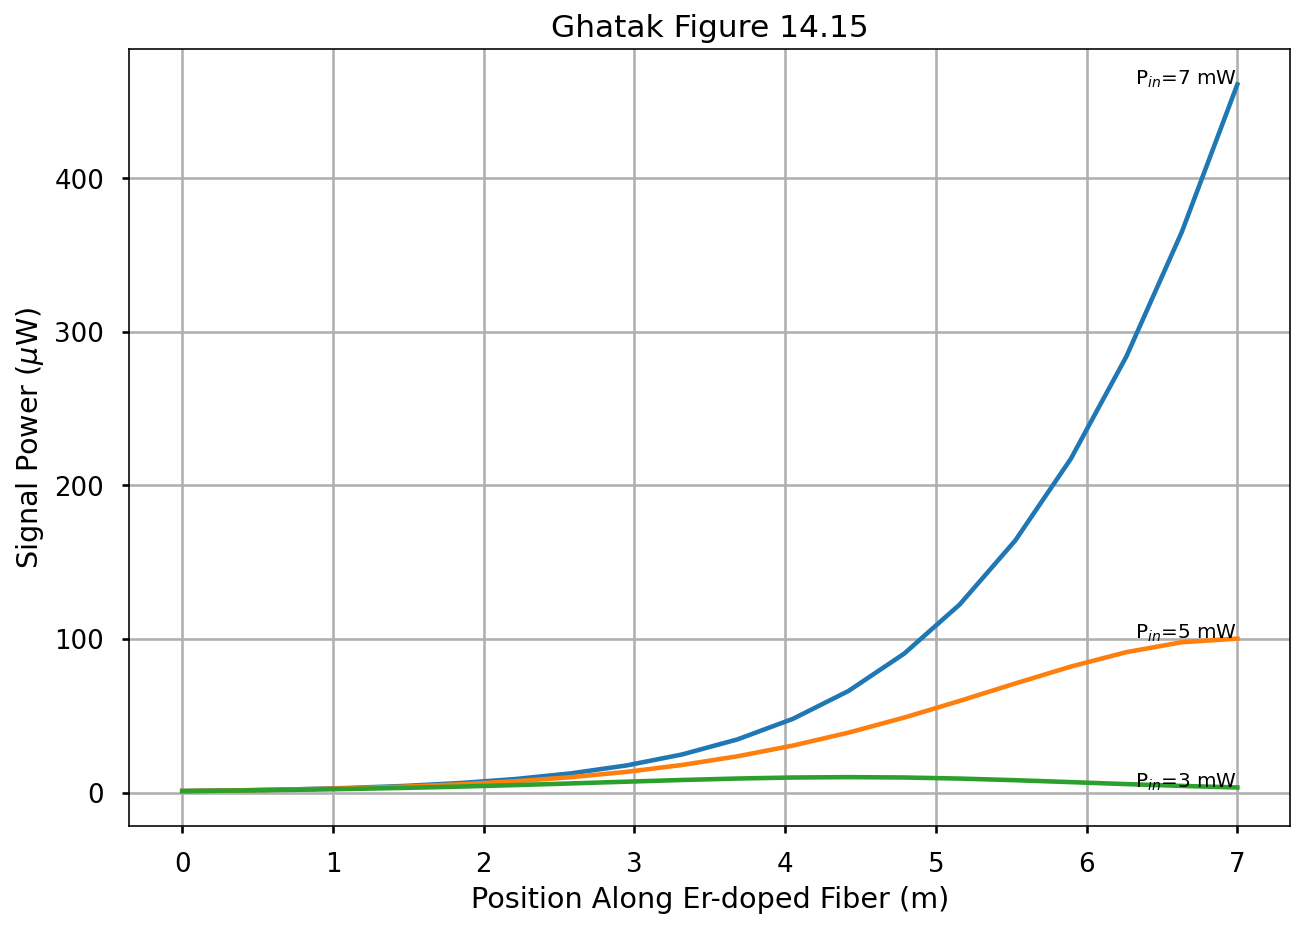

In [7]:
def erbium(y, z, Pp0, A_p, b_over_omega_p, A_s, b_over_omega_s, eta_s):
    '''equation 14.56 and 14.57 in Ghatak'''
    P_p, P_s = y
    p = P_p/Pp0
    dPp_dz = A_p * np.log((1+p*np.exp(-b_over_omega**2))/(1+p))
    dPs_dz = alpha = eta_s * p *(1-np.exp(-b_over_omega_s**2))
    dPs_dz += (1+eta_s)*np.log((1+p*np.exp(-b_over_omega_s**2))/(1+p))
    dPs_dz *= A_s * P_s / P_p
    return [dPp_dz, dPs_dz]


lambda_pump   = 980e-9   # m
lambda_signal = 1550e-9   # m

N_0           = 6.8e24   # Er ions per m**3
core_radius        = 1.64e-6  # m fiber core
doped_radius       =  core_radius   # m Er doping radius
NA            = 0.21

Ip0           = 7.81e7   # W/m**2
Ps0           = 1e-6     # W
eta_s         = 1

abs_pump    = 2.17e-25    # m**2
abs_signal  = absorption_cross_section(lambda_signal)
ems_signal  = emission_cross_section(lambda_signal)
eta_s       = ems_signal/abs_signal

V_pump = ofiber.V_parameter( core_radius, NA, lambda_pump)
Omega_pump = ofiber.gaussian_envelope_Omega(V_pump) *  core_radius

V_signal = ofiber.V_parameter( core_radius, NA, lambda_signal)
Omega_signal = ofiber.gaussian_envelope_Omega(V_signal) *  core_radius

b_over_omega_p = doped_radius / Omega_pump
b_over_omega_s = doped_radius / Omega_signal

Pp0 = Ip0 * np.pi * Omega_pump**2
A_p = N_0 * abs_pump * Pp0
A_s = N_0 * abs_signal * Pp0

z = np.linspace(0,7,20)  # meters along doped fiber

Pin = 7 # mW
sol = scipy.integrate.odeint(erbium, [Pin*1e-3,Ps0], z, args=(Pp0, A_p, b_over_omega_p, A_s, b_over_omega_s, eta_s))
Pp = sol[:,0]
Ps = sol[:,1]*1e6
plt.plot(z,Ps)
plt.text(z[-1],Ps[-1],"P$_{in}$=%.0f mW" % Pin, ha='right')

Pin = 5 # mW
sol = scipy.integrate.odeint(erbium, [Pin*1e-3,Ps0], z, args=(Pp0, A_p, b_over_omega_p, A_s, b_over_omega_s, eta_s))
Pp = sol[:,0]
Ps = sol[:,1]*1e6
plt.plot(z,Ps)
plt.text(z[-1],Ps[-1],"P$_{in}$=%.0f mW" % Pin, ha='right')

Pin = 3 # mW
sol = scipy.integrate.odeint(erbium, [Pin*1e-3,Ps0], z, args=(Pp0, A_p, b_over_omega_p, A_s, b_over_omega_s, eta_s))
Pp = sol[:,0]
Ps = sol[:,1]*1e6
plt.plot(z,Ps)

plt.text(z[-1],Ps[-1],"P$_{in}$=%.0f mW" % Pin, ha='right')

plt.xlabel("Position Along Er-doped Fiber (m)")
plt.ylabel("Signal Power ($\mu$W)")
plt.title("Ghatak Figure 14.15")
plt.grid(True)
plt.show()

## Figures 14.16

Exactly the same as above, but take the log of the results

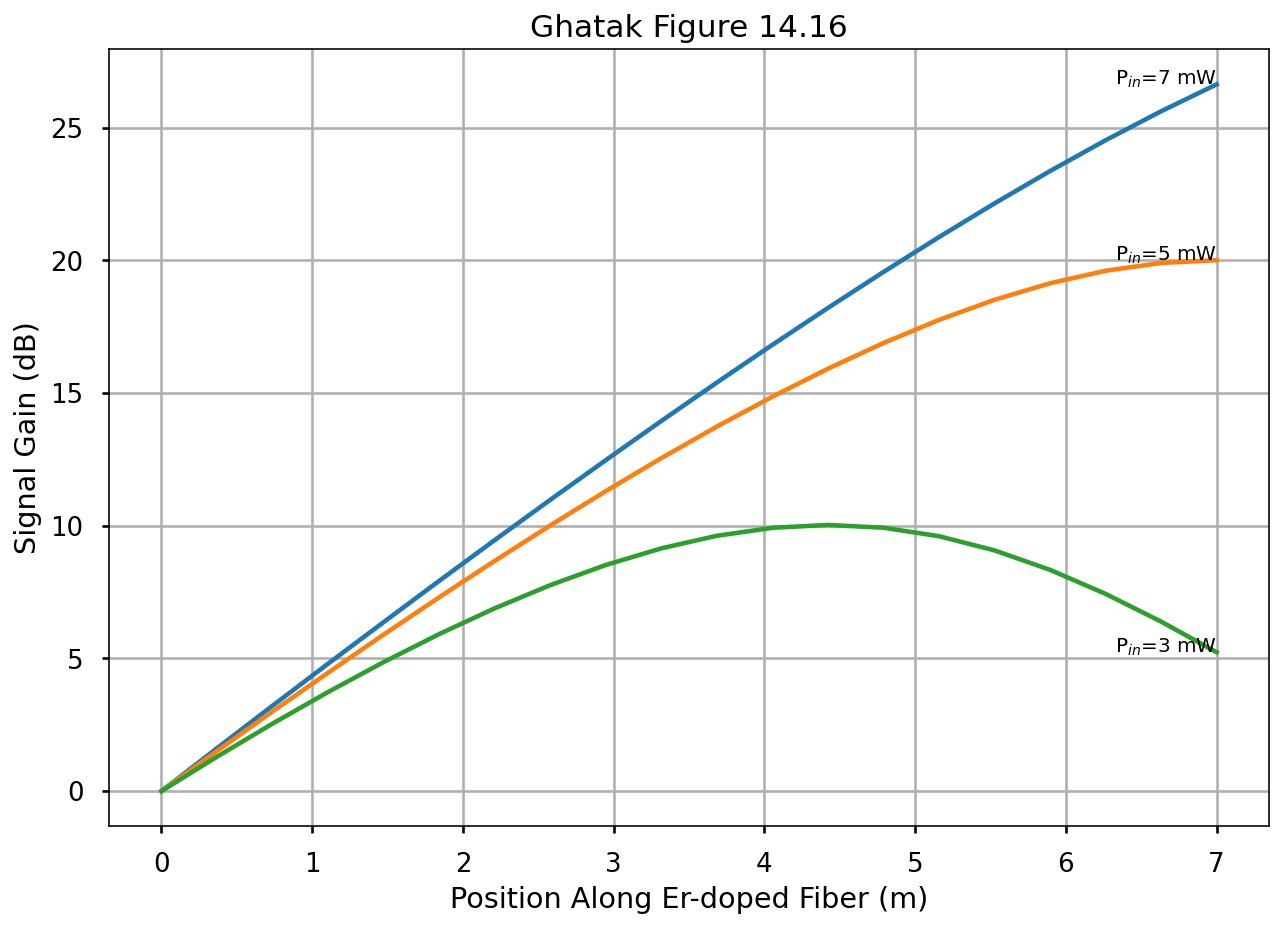

In [8]:
Pin = 7 # mW
sol = scipy.integrate.odeint(erbium, [Pin*1e-3,Ps0], z, args=(Pp0, A_p, b_over_omega_p, A_s, b_over_omega_s, eta_s))
Pp = sol[:,0]
Ps = 10*np.log10(sol[:,1]/Ps0)
plt.plot(z,Ps)
plt.text(z[-1],Ps[-1],"P$_{in}$=%.0f mW" % Pin, ha='right')

Pin = 5 # mW
sol = scipy.integrate.odeint(erbium, [Pin*1e-3,Ps0], z, args=(Pp0, A_p, b_over_omega_p, A_s, b_over_omega_s, eta_s))
Pp = sol[:,0]
Ps = 10*np.log10(sol[:,1]/Ps0)
plt.plot(z,Ps)
plt.text(z[-1],Ps[-1],"P$_{in}$=%.0f mW" % Pin, ha='right')

Pin = 3 # mW
sol = scipy.integrate.odeint(erbium, [Pin*1e-3,Ps0], z, args=(Pp0, A_p, b_over_omega_p, A_s, b_over_omega_s, eta_s))
Pp = sol[:,0]
Ps = 10*np.log10(sol[:,1]/Ps0)
plt.plot(z,Ps)
plt.text(z[-1],Ps[-1],"P$_{in}$=%.0f mW" % Pin, ha='right')

plt.xlabel("Position Along Er-doped Fiber (m)")
plt.ylabel("Signal Gain (dB)")
plt.title("Ghatak Figure 14.16")
plt.grid(True)
plt.show()

## Problem 14.2

For the fiber parameters given by equation (14.58), assuming low signal power, obtain the threshold pump power required for amplification of the signal at any value of $z$.

2.257e-25
2.5743269230769257e-25
3.407692307692308e-25
1.3484911622805945e-06
1.9500339473533436e-06
Gaussian pump envelope   = 1.35um
Gaussian signal envelope = 1.95um
ns = 1.33
The solution is threshold power = 0.45489300717913156mW
at which the value of the expression is -0.000000
Thus Pp/Pp0 = 0.97


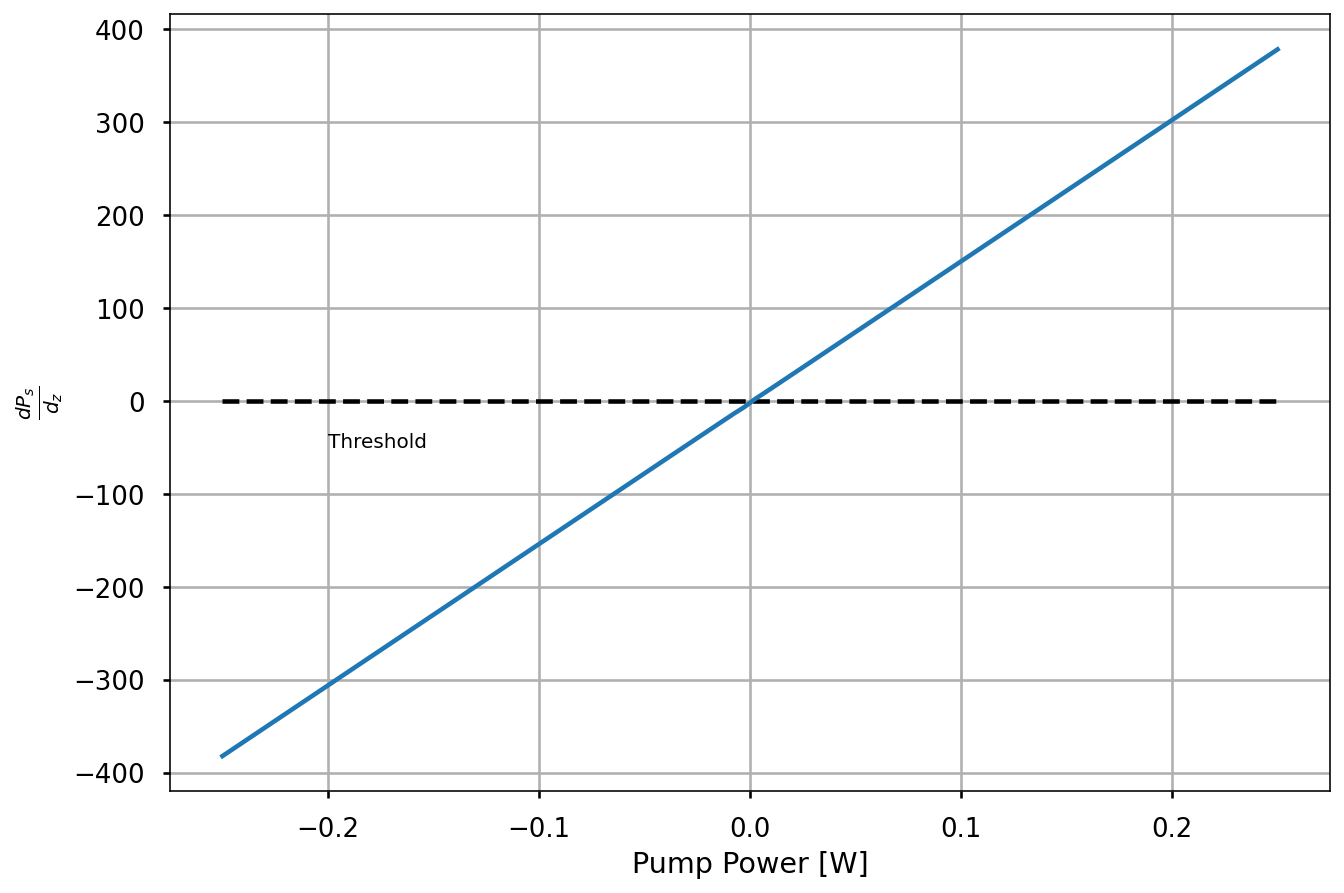

In [9]:
pump_wavelength               = 980e-9  # m
signal_wavelength             = 1550e-9 # m

#typical erbium doped fiber
core_radius      = 1.64e-6  #m r
doped_radius     = 1.64e-6  #m doping_radius
NA          = 0.21

abs_pump   = absorption_cross_section(pump_wavelength)
abs_signal = absorption_cross_section(signal_wavelength)
ems_signal = emission_cross_section(signal_wavelength)

print(abs_pump)
print(abs_signal)
print(ems_signal)

t_sp        = 12e-3    #s
doping_con  = 6.8e24   #m^-3 doping_concentration  
pump_abs    = 2.17e-25 #m^2 pump_absorption_cross_section
signal_abs  = 2.57e-25 #m^2 signal_absorption_cross_section
signal_em   = 3.41e-25 #m^2 signal_emission_cross_section

V_p = ofiber.V_parameter( core_radius, NA,  pump_wavelength)
Omega_p = ofiber.gaussian_envelope_Omega(V_p) *  core_radius
print(Omega_p)

V_s = ofiber.V_parameter( core_radius, NA, signal_wavelength)
Omega_s = ofiber.gaussian_envelope_Omega(V_s) *  core_radius
print(Omega_s)



# solving for the gaussian envelope approximation

ko_pump   = 2*np.pi/pump_wavelength
ko_signal = 2*np.pi/signal_wavelength
Vp = ko_pump*core_radius*NA
Vs = ko_signal*core_radius*NA
Wp = 1.1428*Vp-0.996  #using the approximation from chapter 8.
Ws = 1.1428*Vs-0.996  #using the approximation from chapter 8. (stretching the appoximation criteria out)
Up = np.sqrt(Vp**2-Wp**2)
Us = np.sqrt(Vs**2-Ws**2)

gaussian_pump   = core_radius*scipy.special.j0(Up)*(Vp/Up)*(scipy.special.k1(Wp)/scipy.special.k0(Wp))
gaussian_signal = core_radius*scipy.special.j0(Us)*(Vs/Us)*(scipy.special.k1(Ws)/scipy.special.k0(Ws))
n_s = signal_em/signal_abs

print('''Gaussian pump envelope   = {0:.2f}um
Gaussian signal envelope = {1:.2f}um
ns = {2:.2f}'''.format(gaussian_pump*1e6,gaussian_signal*1e6,n_s))

I_p0 = (h*(c/pump_wavelength))/(pump_abs*t_sp)
P_p0 = np.pi*gaussian_pump**2*I_p0
#print('''Threshold pump Irradiance = {0:.2e} W/m^2
#Threshold pump power = {1:.1e} mW'''.format(I_p0,P_p0*1e3))

#####################################################################################
# To have amplification at any z vaue dPs/dz must be > 0.
#expression whose roots to find

def threshold_Pp (Pp):
    a = (Pp/P_p0)* n_s * (1-np.exp((-core_radius**2/gaussian_signal**2)))
    b = (1+n_s) * np.log((1 + (Pp/P_p0)*np.exp(-core_radius**2/gaussian_signal**2))/(1 + (Pp/P_p0)))
    return a+b

#plotting 
Pp = np.linspace(-.25,.25,100)

plt.plot(Pp,threshold_Pp(Pp))
plt.xlabel("Pump Power [W]")
plt.ylabel("$\\frac{dP_s}{d_z}$")
plt.hlines(0,-.25,.25,colors='k',linestyle='--')
plt.annotate('Threshold',xy=(-.2,-50))
plt.grid()

threshold_initial_guess= 0.05
threshold_solution = scipy.optimize.fsolve(threshold_Pp, threshold_initial_guess)

print ("The solution is threshold power = {0}mW".format(threshold_solution[0] * 1e3))
print ("at which the value of the expression is %f" % threshold_Pp(threshold_solution))
print ('Thus Pp/Pp0 = {:.2f}'.format(P_p0/threshold_solution[0]))
#couldn't get code to produce correct answer from graphs so used easier method below
#####################################################################################

#I_p0 = (h*(c/pump_wavelength))/(pump_abs*t_sp)
#P_p0 = pi*gaussian_pump**2*I_p0
#print('''Threshold pump Irradiance = {0:.2e} W/m^2
#Threshold pump power = {1:.1e} mW'''.format(I_p0,P_p0*1e3))

# Problem 3


In [10]:
signal_wavelength = 1530e-9
signal_em  = 4.36e-25
signal_abs = 5.25e-25

ko_pump   = 2*np.pi/pump_wavelength
ko_signal = 2*np.pi/signal_wavelength

Vs = ko_signal*core_radius*NA
Ws = 1.1428*Vs-0.996  #using the approximation from chapter 8. (stretching the appoximation criteria out)
Us = np.sqrt(Vs**2-Ws**2)

gaussian_signal = core_radius*scipy.special.j0(Us)*(Vs/Us)*(scipy.special.k1(Ws)/scipy.special.k0(Ws))
n_s = signal_em/signal_abs

print('''Gaussian pump envelope   = {0:.2f}um
Gaussian signal envelope = {1:.2f}um
ns = {2:.2f}'''.format(gaussian_pump*1e6,gaussian_signal*1e6,n_s))

I_p0 = (h*(c/pump_wavelength))/(pump_abs*t_sp)
P_p0 = np.pi*gaussian_pump**2*I_p0
#print('''Threshold pump Irradiance = {0:.2e} W/m^2
#Threshold pump power = {1:.1e} mW'''.format(I_p0,P_p0*1e3))

#####################################################################################
# To have amplification at any z vaue dPs/dz must be > 0.
#expression whose roots to find

def threshold_Pp (Pp):
    a = (Pp/P_p0)* n_s * (1-np.exp((-core_radius**2/gaussian_signal**2))) 
    b = (1+n_s) * np.log((1 + (Pp/P_p0)*np.exp(-core_radius**2/gaussian_signal**2))/(1 + (Pp/P_p0)))
    return a+b

threshold_initial_guess= 0.1
threshold_solution = scipy.optimize.fsolve(threshold_Pp, threshold_initial_guess)

print ("The solution is threshold power = {0}mW".format(threshold_solution[0] * 1e3))
print ("at which the value of the expression is %f" % threshold_Pp(threshold_solution[0]))




Gaussian pump envelope   = 1.35um
Gaussian signal envelope = 1.92um
ns = 0.83
The solution is threshold power = 0.7364547431342711mW
at which the value of the expression is -0.000000


# Problem 4

In [11]:

gaussian_pump     = 1.591e-6 #m
gaussian_signal   = 2.288e-6 #m
a                 = 2.5e-6 #m Core Radius
dopping_radius    = [a,a*.5,a*.25,a*.1]
r  = 2.5e-6*.1
signal_wavelength = 1550e-9 #m
ns                = 1.327
pump_abs          = 2.17e-25# m^2
tsp               = 12e-3 #s
pump_wavelength   = 980e-9 #m


I_p0 = (h*(c/pump_wavelength))/(pump_abs*tsp)
Pp0 = np.pi*gaussian_pump**2*I_p0

def threshold_Pp (Pp):
    a = (Pp/Pp0)* ns * (1-np.exp((-r**2/gaussian_signal**2))) 
    b = (1+n_s) * np.log((1 + (Pp/Pp0)*np.exp(-r**2/gaussian_signal**2))/(1 + (Pp/Pp0)))
    return a+b
    

#for d in dopping_radius:
threshold_initial_guess= .6

threshold_sol = scipy.optimize.fsolve(threshold_Pp, threshold_initial_guess)


print ("The solution is threshold power = {0}mW".format(threshold_sol * 1e3))
print ("at which the value of the expression is %f" % threshold_Pp(threshold_sol))


The solution is threshold power = [0.23626214]mW
at which the value of the expression is 0.000000
